In [2]:
import csv
import numpy as np
import pandas as pd
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from patsy import cr
from patsy import dmatrix 

from pprint import pprint
import matplotlib.pyplot as plt
import pylab
import seaborn as sb

from sklearn.metrics import mean_squared_error
from math import sqrt


import sys

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Documents are already written

[Google doc](https://docs.google.com/document/d/18KX24FkL70_Xhxagwx9EBRWeQmz-Ud-iuTXqnf9YXnk/edit?usp=sharing) has some info.

Also the sheet called [Kirti_remotesensing](https://docs.google.com/spreadsheets/d/1KGU_aJwQn-LupWut_Xr999Fct69oMQQdufT6s0ADO-Q/edit?usp=sharing)

## 2017 Irrigated
***Everything here is irrigated. (i.e. non-irrigated is excluded)***

### Eastern Washington

   - Count  : 74,064    = 16,608  (irrigated and annual) + 57,456 (irrigated and perennials)
   - Acreage: 1,864,135 = 834,842 (irrigated and annual) + 1,029,293 (irrigated and perennials)

Irrigated and annual and labeled as double-cropped by Notes column: 532 fields (34,580 acres), in the last 10(?) years. Please note that some of the fields might be double-cropped in 2017 but the Notes column is not an indicator of this fact, since it might be carried over from previous years. So, false positives and false negatives are there.

Breakdown into LastSurveyDate and previous years:

   - Count : 532     = 306    (surveyed in 2017) + 226 (previous years).
   - Acreage: 34,580 = 19,989 (surveyed in 2017) + 14,591 (previous years).
________________________________________________________________________________________________
### Grant county:    
   - Count  : 13,793  = 4,575 (irrigated and annual) + 9,218  (irrigated and perennials)
   - Acreage: 521,766 = 256,314 (irrigated and annual) + 265,452 (irrigated and perennials)

#### Irrigated and annual and labeled as double-cropped by Notes column:

   - Count: 241       = 241    (surveyed in 2017) + 0 (previous years).
   - Acreage: 16,411  = 16,411 (surveyed in 2017) + 0 (previous years).


In [63]:
plot_path = "/Users/hn/Documents/01_research_data/remote_sensing/Sept_18_Meeting/plots_4_slides/"
FontSize = 18

# Eastern Annual vs. Non-annual

In [28]:
Eastern_annual_break = pd.DataFrame({'acreage': [834842, 1029293],
                                     'rounded_acreage': [835000, 1030000]},
                                     index=['annual', 'not-annual'])
Eastern_annual_break

,acreage,rounded_acreage
annual,834842,835000
not-annual,1029293,1030000


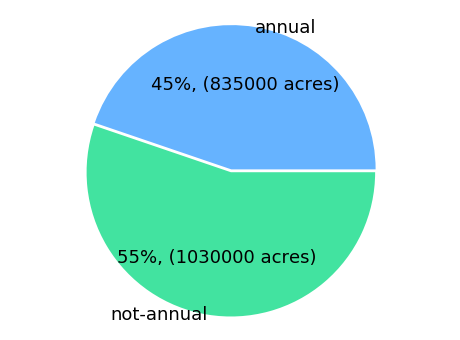

In [29]:
fig, ax = plt.subplots(figsize=(8,6));

ttl = "breakdown of irrigated fields"
explode = (0, 0, 0.02, 0)
explode = (0.02, 0)
colors = ['#66b3ff','#42e3a0', '#ffcc99', '#ff9999']

Eastern_annual_break["rounded_acreage"].plot(kind='pie', 
                # autopct='%1.0f%%',
                autopct = lambda p:f'{p:1.0f}%, ({p*sum(Eastern_annual_break.rounded_acreage)/100 :.0f} acres)',
                labels = Eastern_annual_break.index, 
                labeldistance = 1,
                ax=ax, 
                # title = ttl, 
                fontsize = FontSize,
                shadow = False,
                explode = explode,
                colors = colors
                        )

ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
pylab.ylabel('')
ax.legend().set_visible(False)

fig_name = plot_path + "Eastern_annualVsPerennials.png"
plt.savefig(fname = fig_name, \
            dpi = 400,
            bbox_inches='tight')

### Irrigated and annuals break down into double-cropped by Notes

In [30]:
Eastern_annual_double_break = pd.DataFrame({'acreage': [19989, 14591],
                                            'rounded_acreage': [20000, 14600]},
                             index=['irrigated, annual, double-cropped by Notes, surveyed current year', 
                                    'irrigated, annual, double-cropped by Notes, previous years'])
Eastern_annual_double_break

,acreage,rounded_acreage
"irrigated, annual, double-cropped by Notes, surveyed current year",19989,20000
"irrigated, annual, double-cropped by Notes, previous years",14591,14600


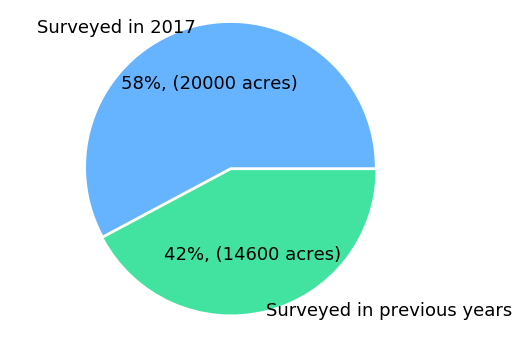

In [31]:
fig, ax = plt.subplots(figsize=(8,6));
col = "acreage"
ttl = "double-cropped (Notes)"
explode = (0, 0, 0.02, 0)
explode = (0.02, 0)
colors = ['#66b3ff','#42e3a0', '#ffcc99', '#ff9999']
LabeLs = ["Surveyed in 2017", "Surveyed in previous years"]

Eastern_annual_double_break["rounded_acreage"].plot(kind='pie', 
             # autopct='%1.0f%%',
             autopct = lambda p:f'{p:1.0f}%, ({p*sum(Eastern_annual_double_break.rounded_acreage)/100 :.0f} acres)',
             labels = LabeLs, 
             labeldistance = 1,
             ax=ax, 
             # title = ttl, 
             fontsize = FontSize,
             shadow = False,
             explode = explode,
             colors = colors
             )

ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
pylab.ylabel('')
ax.legend().set_visible(False)

fig_name = plot_path + "Eastern_annual_doubleSurveyedYears.png"
plt.savefig(fname = fig_name, \
            dpi = 400,
            bbox_inches='tight')

# Grant 2017

In [32]:
Grant_annual_break = pd.DataFrame({'acreage': [256314, 265452],
                                   'rounded_acreage': [256000, 265500]},
                                    index=['irrigated and annual', 'irrigated and not-annual'])
Grant_annual_break

,acreage,rounded_acreage
irrigated and annual,256314,256000
irrigated and not-annual,265452,265500


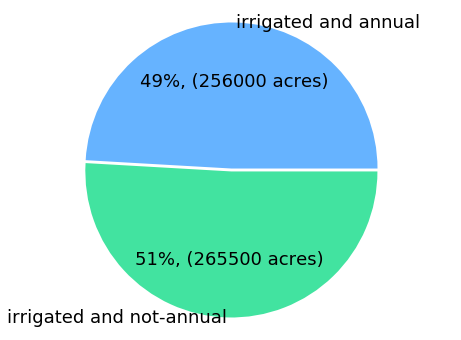

In [34]:
fig, ax = plt.subplots(figsize=(8,6));

ttl = "breakdown of irrigated fields to annual and others."
explode = (0, 0, 0.02, 0)
explode = (0.02, 0)
colors = ['#66b3ff','#42e3a0', '#ffcc99', '#ff9999']

Grant_annual_break["rounded_acreage"].plot(kind='pie', 
                        # autopct='%1.0f%%',
                        autopct = lambda p:f'{p:1.0f}%, ({p*sum(Grant_annual_break.rounded_acreage)/100 :.0f} acres)',
                        labels = Grant_annual_break.index, 
                        labeldistance = 1,
                        ax=ax, 
                        # title = ttl, 
                        fontsize = FontSize,
                        shadow = False,
                        explode = explode,
                        colors = colors
                        )

ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
pylab.ylabel('')
ax.legend().set_visible(False)

fig_name = plot_path + "Grant_annualVsPerennials.png"
plt.savefig(fname = fig_name, \
            dpi = 400,
            bbox_inches='tight')

### Irrigated and annuals break down into double-cropped by Notes

In [35]:
Grant_annual_double_break = pd.DataFrame({'acreage': [16411, 0],
                                          'rounded_acreage': [16500, 0]},
                             index=['irrigated, annual, double-cropped by Notes, surveyed current year', 
                                    'irrigated, annual, double-cropped by Notes, previous years'])
Grant_annual_double_break

,acreage,rounded_acreage
"irrigated, annual, double-cropped by Notes, surveyed current year",16411,16500
"irrigated, annual, double-cropped by Notes, previous years",0,0


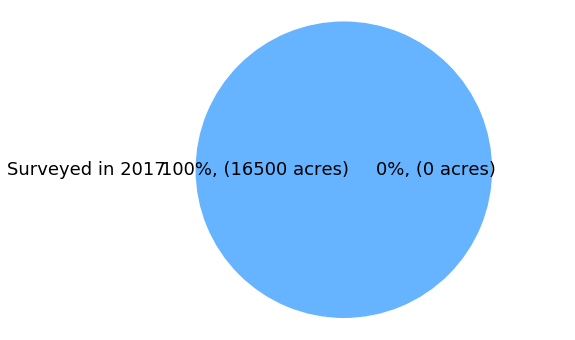

In [36]:
fig, ax = plt.subplots(figsize=(8,6));

ttl = "labeled as double-cropped by Notes (irrigated and annual fields)."
explode = (0, 0, 0.02, 0)
explode = (0.02, 0)
colors = ['#66b3ff','#42e3a0', '#ffcc99', '#ff9999']
LabeLs = ["Surveyed in 2017", "Surveyed in previous years"]

Grant_annual_double_break["rounded_acreage"].plot(kind='pie', 
                         # autopct='%1.0f%%',
             autopct = lambda p:f'{p:1.0f}%, ({p*sum(Grant_annual_double_break.rounded_acreage)/100 :.0f} acres)',
             labels = LabeLs, 
             labeldistance = 1.2,
             ax=ax, 
             # title = ttl, 
             fontsize = FontSize,
             shadow = False,
             explode = explode,
             colors = colors
             )

ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
pylab.ylabel('')
ax.legend().set_visible(False)

plot_path = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/Sept18_Meeting/"
fig_name = plot_path + "Grant_annual_doubleSurveyedYears.png"
plt.savefig(fname = fig_name, \
            dpi = 400,
            bbox_inches='tight')

In [91]:
A = create_date_table2(SF_year=2016)
A.shape

(366, 3)

In [93]:
A.tail(2)

,Date,SF_year,doy
364,2016-12-30,2016,365
365,2016-12-31,2016,366


#### break down annuals and irrigated to double-cropped vs. not-double-cropped

# Did this in R

In [43]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/01_Data_part_not_filtered/"
needed_counties = ["Grant", "Frankling", "Adams", "Benton", "Yakima", "Walla Walla"]

In [39]:
wsda_2017 = pd.read_csv(data_dir + "WSDA_DataTable_2017.csv")

wsda_2017 = wsda_2017[wsda_2017.county.isin(needed_counties)]
wsda_2017.Notes = wsda_2017.Notes.astype(str)
wsda_2017.Notes = wsda_2017.Notes.str.lower()

wsda_2017_dbl = wsda_2017[wsda_2017['Notes'].str.contains('dbl')]
wsda_2017_double = wsda_2017[wsda_2017['Notes'].str.contains('double')]
wsda_2017_double = pd.concat([wsda_2017_double, wsda_2017_dbl])
wsda_2017_double.shape